<a href="https://colab.research.google.com/github/jairsilva0742/RedesNeuronales/blob/main/Calculo_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
from scipy.optimize import minimize, fsolve

In [ ]:
costos=[]

In [ ]:
#Constantes fijas
n=1 #Numero de pasos
CTP=0.93 #constante de conteo de tubos para 1 paso
CL=0.866 # constante de arreglo  de tubos triangulares
Kw=42.7 #W/mK conductividad termica de aleación de cromo
DeltaP=10 #maxima caida de presión permitida en kPa
      
# Constantes de liquido caliente, Aceite motor en tubos
moil=0.23 #Flujo másico(kg/s)
Ti_oil=120 #Temp. entrada(°C)
To_oil=115 #Temp. salida(°C)
F_Ens_oil=0.176e-3 #Factor de ensuciamiento Aceite m2 K/W   
#Propiedades usando la temperatura media
rho_oil=828 #Densidad(kg/m3)
Cp_oil=2.307 #Capacidad calorífica(KJ /kg K)
mu_oil=1.027e-2 #Viscosidad dinámica (Pa*s)
k_oil=0.135 #Conductividad Térmica (W/m K)
Pr_oil=175 #Prandalt
      
# Constantes de liquido frio, Ethylen glycol
methy=0.47 #Flujo másico(kg/s)
Ti_ethy=90 #Temp. entrada(°C)
F_Ens_Ethy=0.353e-3 #Factor de ensuciamiento Aceite m2 K/W     
#Propiedades usando la temperatura media (se asume la temperatura de salida de 100 °C)
rho_ethy=1020 #Densidad(kg/m3)
Cp_ethy=3.650 #Capacidad calorífica(KJ /kg K)
mu_ethy=0.08e-2 #Viscosidad dinámica (Pa*s)
k_ethy=0.442 #Conductividad Térmica (W/m K)
Pr_ethy=6.6 #Prandalt

#Se define una variable global que despues se modifica [Ds, do ,B]
x= [50, 3.154, 20]


In [ ]:
def FactorFriccion(Re):
  if Re>2300:
    f=((1.58*math.log(Re))-3.28)**(-2)
  else:
    f=16/Re

  return f

In [ ]:
def NT(x):
  Ds=x[0]# Diametro interno coraza (mm)
  do=x[1]#Diametro Tubo externo (mm)
  #Estimacion de numero de tubos - Datos en mm
  Nt=round((math.pi/4)*(CTP/CL)*(Ds**2/(1.25**2*do**2)))
  return Nt

In [ ]:
def De(x):
  
  do=x[1]#Diametro Tubo externo (mm)
  #Paso de tubo
  Pt=1.25*do
  #Calculo de Diametro Equivalente (mm)
  De=4*((((Pt**2)*(3**0.5)/4)-(math.pi*(do**2)/8))/(math.pi*do/2))
  return De

In [ ]:
def ecuacion(y):
  Ds=x[0]# Diametro interno coraza (mm)
  do=x[1]#Diametro Tubo externo (mm)
  B=x[2]#Espaciamiento baffle (mm)
  L=y #Longitud tuberia (mm)

  #Calculo de tasa de diametros
  di=do/1.3
  #Paso de tubo
  Pt=1.25*do
  #Bafles
  Nb=(L/B)-1
  #liquidacion de tubo
  Ct=Pt-do
  #Se calcula NT por medio de otra funcion
  Nt=NT(x)

  #CALCULOS DEL LADO DE LOS TUBOS
  #Se pasa el dato de di a metros
  Ac_tubos=(math.pi/4)*(di/1000)**2*(Nt/n)
   #calculo de velocidad
  v_oil=moil/(rho_oil*Ac_tubos)
  #Calculo de Reynolds
  Re_oil=rho_oil*v_oil*(di/1000)/mu_oil
  #calculo de factor de fricción por medio de Función
  f=FactorFriccion(Re_oil)
  #calculo de numero de Nusselt  
  if Re_oil>2300:
    Nu_tubo=(f/2)*((Re_oil-1000)*Pr_oil/(1+((12.7*f/2)**(0.5*(Pr_oil**(2/3))-1))))
  else:
    Nu_tubo=1.86*(Re_oil*Pr_oil*di/L)**(1/3)
  #Calculo de transferencia por convección
  h_tubo=Nu_tubo*k_oil/(di/1000)

  #CALCULOS DEL LADO DE LA CORAZA
  #Se pasa el dato de di a metros
  Ac_coraza=(Ds/1000)*Ct*(B/1000)/Pt
  #calculo de velocidad
  v_ethy=methy/(rho_ethy*Ac_coraza)
  #Calculo de Diametro Equivalente (mm)
  De=4*((((Pt**2)*(3**0.5)/4)-(math.pi*(do**2)/8))/(math.pi*do/2))
  #Numero de Reynolds
  Re_ethy=rho_ethy*v_ethy*(De/1000)/mu_ethy
  #Numero de Nusselt
  Nu_coraza=0.36*(Re_ethy**0.55)*(Pr_ethy)**(1/3)
  #Calculo de transferencia por convección
  h_coraza=Nu_coraza*k_ethy/(De/1000)

  #Calculo de Areas de transferencia para ambos fluidos
  A_int=math.pi*(di/1000)*(L/1000)*Nt
  A_ext=math.pi*(do/1000)*(L/1000)*Nt
  #calculo de Coeficiente global de transferencia de calor
  Uo=(1/A_ext)/((1/(h_tubo*A_int))+(F_Ens_oil/A_int)+((math.log(do/di))/(2*math.pi*(L/1000)*Kw))+(F_Ens_Ethy/A_ext)+((1/(h_coraza*A_ext))))

  #Se usa el método NTU
  C_Oil=moil*Cp_oil*1000
  C_ethy=methy*Cp_ethy*1000
  C_min=min(C_Oil,C_ethy)
  C_max=max(C_Oil,C_ethy)
  Cr=C_min/C_max
  #Se calcula el valor de NTU
  NTU=Uo*A_ext/C_min
  #La efectividad del intercambiador se calcula de la siguiente forma
  epsilon=2*(1+Cr+((1+(Cr**2))**0.5*((1+(math.exp((-NTU)*(1+(Cr**2))**0.5)))/(1-(math.exp((-NTU)*(1+(Cr**2))**0.5))))))**(-1)
  #Se calculan las temperaturas de Salida
  To_Oil_Calculada=Ti_oil-(epsilon*C_min/C_Oil*(Ti_oil-Ti_ethy))
  #La diferencia es la funcion objetivo
  diferencia=abs(To_Oil_Calculada-To_oil)
  To_ethy_Calculada=Ti_ethy+(epsilon*C_min/C_ethy*(Ti_oil-Ti_ethy))

  return diferencia




In [ ]:
def resolver(xnueva):
  global x
  x=xnueva
  s=fsolve(ecuacion,800)
  #print('Longitud',s)
  return s

In [ ]:

resolver(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in power


array([339.7366477])

In [ ]:
def objetivo2(x):
  Ds=x[0] #Diametro interno coraza (mm)
  do=x[1] #Diametro Tubo externo (mm)
  B=x[2]  #Espaciamiento baffle (mm)
  L=resolver(x) #Longitud tuberia (mm)
  Nt=NT(x)
  A =  L/1000*(math.pi*do*Nt)
  Nb=(L/B)-1

  Pt=1.25*do
  Ct=Pt-do 
  st=1.25*do
  di=0.8*do
  #Calculos de caida de presión de aceite
  vc=(moil/(0.25*math.pi*(di)**2*rho_oil))*n/Nt
  Re_oil=rho_oil*vc*(di)/mu_oil
  pt=4*((FactorFriccion(Re_oil)*L/di)+1)*1/2*rho_oil*(vc**2)/1e3

  #Calculos de caida de presión de ethylen glicol
  De2=De(x)
  Ac_coraza=(Ds/1000)*Ct*(B/1000)/Pt
  v_ethy=methy/(rho_ethy*Ac_coraza)
  Re_ethy=rho_ethy*v_ethy*(De2/1000)/mu_ethy 
  ps=FactorFriccion(Re_ethy)*Ds/De2*(Nb+1)*1/2*rho_ethy*(v_ethy**2)/1e3

  #Se realiza el costeo operativo del bombeo acuerdo a las caidas de presión y los costos fijos
  #Constantes para intercambiadores de calor
  a1 = 8000
  a2 = 259.2
  a3 = 0.93
  ce = 0.12 #Costo energia
  H = 7000 #Operacion anual en horas
  eff = 0.7 #Eficiencia de la bomba
  Ctot = (a1 + a2*A**a3)+ (ce*H*(moil*pt/rho_oil + methy*ps/rho_ethy)/eff)
  #print('cost',Ctot)
  costos.append(Ctot)

  return Ctot

In [ ]:
objetivo2(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in power


array([85287.1062071])

In [ ]:
def restriccionDsInferior(x):
  Ds=x[0] #Diametro interno coraza (mm)
  do=x[1] #Diametro Tubo externo (mm)
  B=x[2]  #Espaciamiento baffle (mm)
  return Ds-50

In [ ]:
def restriccionDsSuperior(x):
  Ds=x[0] #Diametro interno coraza (mm)
  do=x[1] #Diametro Tubo externo (mm)
  B=x[2]  #Espaciamiento baffle (mm)
  return 500-Ds

In [ ]:
def restriccionDoInferior(x):
  Ds=x[0] #Diametro interno coraza (mm)
  do=x[1] #Diametro Tubo externo (mm)
  B=x[2]  #Espaciamiento baffle (mm)
  return do-1

In [ ]:
def restriccionDoSuperior(x):
  Ds=x[0] #Diametro interno coraza (mm)
  do=x[1] #Diametro Tubo externo (mm)
  B=x[2]  #Espaciamiento baffle (mm)
  return 25-do

In [ ]:
def restriccionBInferior(x):
  Ds=x[0] #Diametro interno coraza (mm)
  do=x[1] #Diametro Tubo externo (mm)
  B=x[2]  #Espaciamiento baffle (mm)
  return B-10

In [ ]:
def restriccionBSuperior(x):
  Ds=x[0] #Diametro interno coraza (mm)
  do=x[1] #Diametro Tubo externo (mm)
  B=x[2]  #Espaciamiento baffle (mm)
  return 100-B

In [ ]:
restriccionDsInferior={'type': 'ineq', 'fun': restriccionDsInferior}
restriccionDsSuperior={'type': 'ineq', 'fun': restriccionDsSuperior}

restriccionDoInferior={'type': 'ineq', 'fun': restriccionDoInferior}
restriccionDoSuperior={'type': 'ineq', 'fun': restriccionDoSuperior}

restriccionBInferior={'type': 'ineq', 'fun': restriccionBInferior}
restriccionBSuperior={'type': 'ineq', 'fun': restriccionBSuperior}

rest=[restriccionDsInferior,restriccionDsSuperior, restriccionDoInferior,restriccionDoSuperior, restriccionBInferior, restriccionBSuperior]
print(rest)

[{'type': 'ineq', 'fun': <function restriccionDsInferior at 0x7ff13fcf7830>}, {'type': 'ineq', 'fun': <function restriccionDsSuperior at 0x7ff13fcf77a0>}, {'type': 'ineq', 'fun': <function restriccionDoInferior at 0x7ff13fcf75f0>}, {'type': 'ineq', 'fun': <function restriccionDoSuperior at 0x7ff13fcf7560>}, {'type': 'ineq', 'fun': <function restriccionBInferior at 0x7ff13fcf73b0>}, {'type': 'ineq', 'fun': <function restriccionBSuperior at 0x7ff13fcf7320>}]


In [ ]:
x0= [55, 6, 35]
sol=minimize(objetivo2, x0, constraints=rest, method='trust-constr')
print('Ds=', sol.x[0], 'do=', sol.x[1], 'B=', sol.x[2])
sol.fun
sol.niter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in power


Ds= 50.00074180518328 do= 3.360546831232169 B= 10.003912914313913


1000

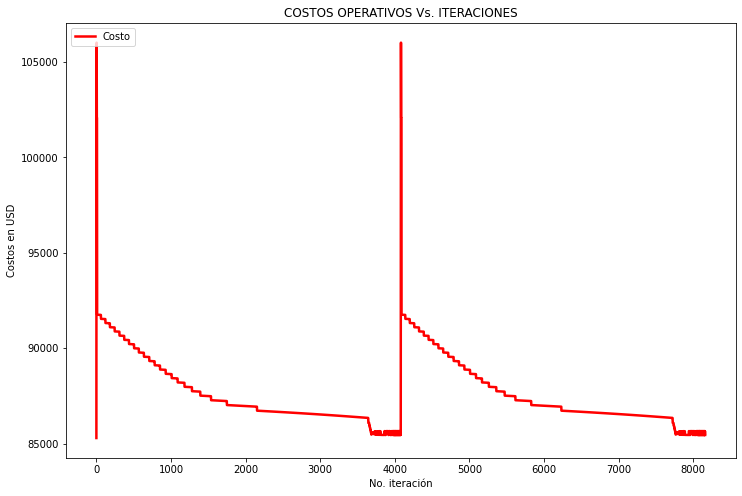

In [ ]:
import matplotlib.pyplot as plt

nuevoCosto=[]
costos=np.array(costos)
#Se decartan datos atipicos
media = (costos).mean()
std_x = (costos).std()*2

for item in range(len(costos)):
  if abs(costos[item]-media)>std_x:
    
    np.delete(costos,item)
  else:
    nuevoCosto.append(costos[item])
xit=[]
for item in range(len(nuevoCosto)):
  xit.append(item)
plt.figure(figsize=(12,8))
plt.plot(xit,nuevoCosto, color="red",  linewidth=2.5, linestyle="-", label="Costo")
plt.legend(loc='upper left')
plt.xlabel('No. iteración')
plt.ylabel('Costos en USD')
plt.title('COSTOS OPERATIVOS Vs. ITERACIONES')
plt.show()


In [ ]:
# Funciones de Algortimo Genetico para Optimizar
def prueba_aptitud(X):
    # Se realiza prueba de aptitud a cada terna de datos introducida (Fitness)
    fitness=np.zeros(len(X),)    
    for fila in range(len(X)):
      fitness[fila]= objetivo2(X[fila])
          
    
    return fitness

def seleccion(pop, fitness, num_parents):
    # Se realiza la selección de padres, los cuales son los que tienen mejor la mejor aptitud o minimo de costos
    parents = np.empty((num_parents, pop.shape[1]))
    #print('Mejor valor es',fitness[np.where(fitness == np.min(fitness))],' Donde los datos son: Ds',pop[np.where(fitness == np.min(fitness)),0], ' do ',pop[np.where(fitness == np.min(fitness)),1],' B ',pop[np.where(fitness == np.min(fitness)),2])
    CostosGeneticos.append(fitness[np.where(fitness == np.min(fitness))])
    MejoresDimensiones.append(pop[np.where(fitness == np.min(fitness))])
    for parent_num in range(num_parents):
        min_fitness_idx = np.where(fitness == np.min(fitness))
        min_fitness_idx = min_fitness_idx[0][0]
        parents[parent_num, :] = pop[min_fitness_idx, :]
        #Se cambia el valor anterior de aptitud, ya que para obtener un nuevo minimo se descarta el tado ya tomado
        fitness[min_fitness_idx] = 99999999999

    return parents

def cruce(parents, offspring_size):
    offspring = np.empty(offspring_size)
    # El punto en el que se hace el cruce de datos es la mitad o segundo indice
    crossover_point = np.uint8(offspring_size[1]/2)
    
    for k in range(offspring_size[0]):
        # Indice del primer padre a acompañar
        parent1_idx = k%parents.shape[0]
        # Indice del primer padre a acompañar
        parent2_idx = (k+1)%parents.shape[0]
        # La nueva generacion tendra la primera mitad de genes del primer padre.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # La nueva generacion tendra la segunda mitad de genes del segundo padre.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
  
    return offspring

def mutacion(offspring_crossover):
    # Mutacion cambia un gen aleatoriamente
    for idx in range(offspring_crossover.shape[0]):
        # este es el valor random a modificar de cada gen
        random_value = np.random.uniform(-1.0, 1.0, 1)
        #Se recomienda valro de 0.1.
        #se escoge aleatoriamente que gen se va a modificar (Ds, do ó B)
        indx=round(np.random.rand()*2)
        offspring_crossover[idx, indx]=abs(offspring_crossover[idx, indx] + random_value)
               

    return offspring_crossover

In [ ]:
sol_per_pop = 20
num_parents_mating = 8
# Se define el tamaño de la población
pop_size = (sol_per_pop,1) # The population will have sol_per_pop chromosome where each chromosome has num_weights genes.
#Se crea la población inicial con ciertas restricciones
new_population_Ds = np.random.uniform(low=50, high=500, size=pop_size)
new_population_do = np.random.uniform(low=1, high=25, size=pop_size)
new_population_B = np.random.uniform(low=10, high=100, size=pop_size)
new_population=np.hstack((new_population_Ds,new_population_do,new_population_B))
print(new_population)


[[403.9658881    1.78857853  21.3432965 ]
 [ 79.86232736   8.88287298  41.7095344 ]
 [163.69172048   2.77349013  22.63033986]
 [ 58.94093164  20.03390069  77.98086852]
 [396.46822032  16.36274062  26.46676197]
 [252.05262141   8.74603031  60.38641568]
 [ 68.83557036  10.63293063  50.6067149 ]
 [257.62724505   1.44386229  43.80264345]
 [107.26884657  22.22180498  36.5849459 ]
 [204.9751784   24.21107655  69.1627127 ]
 [229.51232784  11.17681072  24.51489433]
 [360.95737494  20.61861605  60.35799021]
 [ 71.30490332  18.53115513  72.24716682]
 [268.59760348   1.040443    27.63155431]
 [235.65784786   3.72696214  49.19821363]
 [235.61702907  17.32284535  58.11972856]
 [128.71051162   2.22065473  36.49852258]
 [129.45261024  12.36909812  51.80861033]
 [414.44959589  15.8635791   82.1710601 ]
 [196.12546555  24.70131729  40.34044904]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in power


Generación:  0
POblación
[[ 79.86232736   8.88287298  41.7095344 ]
 [ 68.83557036  10.63293063  50.6067149 ]
 [129.45261024  12.36909812  51.80861033]
 [ 71.30490332  18.53115513  72.24716682]
 [ 58.94093164  20.03390069  77.98086852]
 [107.26884657  22.22180498  36.5849459 ]
 [229.51232784  11.17681072  24.51489433]
 [235.61702907  17.32284535  58.11972856]
 [ 79.86232736  11.31181101  50.6067149 ]
 [ 68.83557036  12.02443758  51.80861033]
 [129.45261024  18.34672461  72.24716682]
 [ 71.30490332  20.03390069  78.24564854]
 [ 58.94093164  22.22180498  36.15787151]
 [107.26884657  10.30604545  24.51489433]
 [229.51232784  17.32284535  58.74281324]
 [235.61702907   8.5549373   41.7095344 ]
 [ 79.11340189  10.63293063  50.6067149 ]
 [ 69.44105505  12.36909812  51.80861033]
 [129.45261024  18.36609026  72.24716682]
 [ 71.30490332  19.3828994   77.98086852]]
Generación:  1
POblación
[[ 79.86232736   8.88287298  41.7095344 ]
 [ 68.83557036  10.63293063  50.6067149 ]
 [ 79.11340189  10.632930

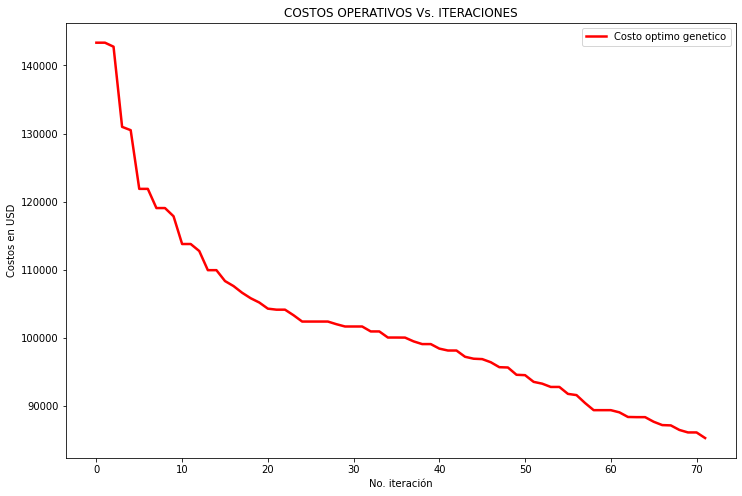

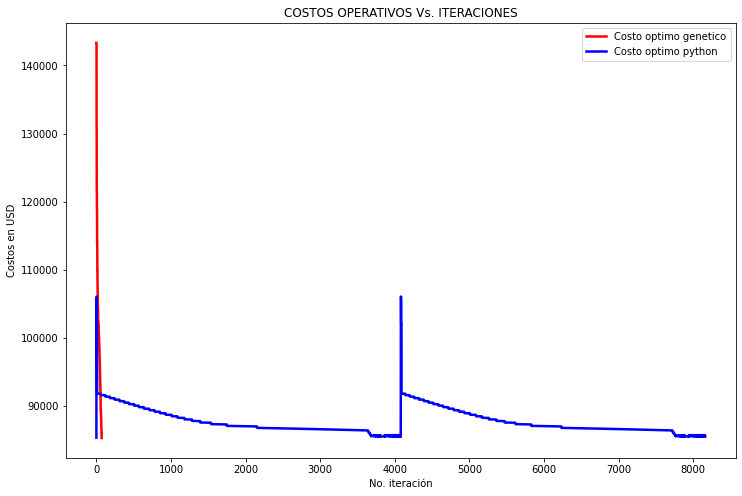

In [ ]:
#Acá se ejecuta el algoritmo genético

costos=[]
CostosGeneticos=[]
MejoresDimensiones=[]
zz=40
i=0
while zz>0.0003:
  # Teniendo en cuenta los valores aleatorios, se lleva a cabo la prueba con este par de datos
  fitness = prueba_aptitud(new_population)
  print('Generación: ',i)

  #Se obtiene el grupo de datos con la mejor minimización
  parents = seleccion(new_population, fitness,num_parents_mating)
    
  #Se obtiene la generación cruzada
  offspring_crossover = cruce(parents,offspring_size=(pop_size[0]-parents.shape[0], 3))
 
  #Se realiza la respectiva mutación a la generación cruzada
  offspring_mutation = mutacion(offspring_crossover)

  #De los padres y cruces se obtiene una nueva generación mejorada
  new_population[0:parents.shape[0], :] = parents
  new_population[parents.shape[0]:, :] = offspring_mutation
  print('POblación')
  print(new_population)



  i=i+1
  if i>7:
    #este es el valor que se usará como criterio de parada, el cual es que la diferencia entre la ultima solución y otra que sea de 5 posiciones atrás
    #Sea inferior a 0.00003. Se toman estos valores algo alejados ya que se garantiza continuidad en el valor objetivo.
    zz=abs(CostosGeneticos[len(CostosGeneticos)-1]-CostosGeneticos[len(CostosGeneticos)-6])

  #Este bucle se usa para acabar la iteración cuando algun item uncimpla las restricciones
  for item in new_population:
    if item[0]<50:
      print('Item invalido de DS')
      print(item[0])
      zz=0
    elif item[2]<10:
      print('Item invalido de B')
      print(item[2])
      zz=0
print('Numero de iteraciones')
print(i)
print('Valor Optimo de Costo')
print('USD ',round(min(CostosGeneticos)[0],1))
print('Valores Optimos de Dimensiones')
print('Ds: ',round(MejoresDimensiones[CostosGeneticos.index(min(CostosGeneticos))][0][0],3),' do: ',round(MejoresDimensiones[CostosGeneticos.index(min(CostosGeneticos))][0][1],3),'B: ',round(MejoresDimensiones[CostosGeneticos.index(min(CostosGeneticos))][0][2],3))
    

x2t=[]
for item in range(len(CostosGeneticos)):
  x2t.append(item)
plt.figure(figsize=(12,8))
plt.plot(x2t,CostosGeneticos, color="red",  linewidth=2.5, linestyle="-", label="Costo optimo genetico")
plt.legend(loc='upper right')
plt.xlabel('No. iteración')
plt.ylabel('Costos en USD')
plt.title('COSTOS OPERATIVOS Vs. ITERACIONES')
plt.show()
plt.figure(figsize=(12,8))
plt.plot(x2t,CostosGeneticos, color="red",  linewidth=2.5, linestyle="-", label="Costo optimo genetico")
plt.plot(xit,nuevoCosto, color="blue",  linewidth=2.5, linestyle="-", label="Costo optimo python")
plt.legend(loc='upper right')
plt.xlabel('No. iteración')
plt.ylabel('Costos en USD')
plt.title('COSTOS OPERATIVOS Vs. ITERACIONES')
plt.show()

